# 20 Newsgroup Document Classification

This project focuses on classifying the 20 news data using machine learning algorithms. It is a supervised classification problem, there are news of 20 categories where each piece of news belongs to one category.
 
The goal is to extract proper features and build an effective model to assign each piece of news to one of the 20 categories.  
 
I will explore the dataset in the beginning on the training part by extracting useful keywords and build vectors of features from the texts of news. Then I will use several classification methods to do classification based upon those vectors and then compare the efficiency of these classifiers on the test data and choose one. I will also use gridsearch to find the best parameters for classifiers.

## Dataset
I will apply classification algorithms on 20 newsgroup dataset from CMU Text Learning Group Data Archives. It has a collection of 20,000 messages, collected from 20 different newsgroups. The news will be classified according to their contents
The data is organized into 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale / soc.religion.christian). 

20news-bydate.tar.gz unpacks into two top-level directories: 20news-bydate-train and 20news-bydate-test. Both of these contain 20 subdirectories of newsgroup data, where the directory name is the same as the newsgroup name, and each of these contains a set of newsgroup messages, roughly 400—600 posts for the training sets and roughly 250—400 posts for the test sets.


In [2]:

import pandas as pd
import numpy as np

# vectorizer
from sklearn.feature_extraction.text import CountVectorizer,HashingVectorizer,TfidfVectorizer,TfidfTransformer

# Classifiers
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier,RidgeClassifier

import os,codecs
import string

#nltk
import nltk
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV



C:\Users\nnagori\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\nnagori\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:

baseDirectory = "./"

trainingDir = baseDirectory + "20news-bydate-train/"
testDir = baseDirectory + "20news-bydate-test/"

categories = os.listdir(trainingDir)
categories = [filename for filename in categories
                           if os.path.isdir(trainingDir + filename)]
#categories = ['comp.graphics','rec.sport.baseball','sci.med','soc.religion.christian']
categories



['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

# Data Preprocessing

I have used nltk library for sentence and word tokenization. I have removed the punctuation and removed the stop words.

In [151]:

def stop_word(text):
    stopword = stopwords.words('english')
    stopword += string.lowercase[:]   
    content = [w for w in text if w not in stopword]
    return content

In [176]:
def make_xy(dir, categories):
    X=[]
    Y=[]
    filesPerCat={}
    fileStats =[]
    for ind,category in enumerate(categories):
        currentdir = dir + category
        files = os.listdir(currentdir)
        filesPerCat[category] = len(files)
        for fi in files:
            f = codecs.open(currentdir + '/' + fi, 'r', 'iso8859-1')
            content = f.read().lower()      
        
            sen = nltk.tokenize.sent_tokenize(content)   
            #sen_no_punctuation = re.sub("[^a-zA-Z]"," ", str(sen))
            sen_no_punctuation = str(sen).translate(None,string.punctuation)
           
            tokens_no_sw = stop_word(nltk.tokenize.word_tokenize(sen_no_punctuation)) 
                     
            X.append(' '.join(tokens_no_sw))           
            Y.append(ind)
            
            fileStats.append([len(sen),len(tokens_no_sw)])
            
    return X,Y,filesPerCat,fileStats 



### Vectorization - Create X,Y arrays for train and test data

First of all, I extract features from the news data. These features can be words, sentences or phrases or combination of them all. I have considered using single words as features allowing for model complexity. I have used Tf-Idf algorithm to extract features rather than simple word frequencies. The tf-idf value increases proportionally to the number of times a word appears in the document, but is offset by the frequency of the word in the corpus

TfIdf will strip all English “stop words” from the document. Stop words are really common words that don’t contribute to the meaning of the document. It will also filter out terms that occur in more than half of the documents (max_df=0.5).

In [267]:
X_train_data,Y_train_data,trainFilesPerCat,trainFileStats = make_xy(trainingDir, categories)
X_test_data,Y_test_data, testFilesPerCat,testFileStats  = make_xy(testDir, categories)

vectorizer = TfidfVectorizer(stop_words='english',sublinear_tf= True, max_df = 0.5)

X_train = vectorizer.fit_transform(X_train_data)
X_test = vectorizer.transform(X_test_data)

Y_train =np.array(Y_train_data)
Y_test = np.array(Y_test_data)
X_train.shape



(11314, 257851)

# Data Exploration

## Distribution of train and test files per class
It can be seen that each class has almost same number of files and thus data seems to be balanced.

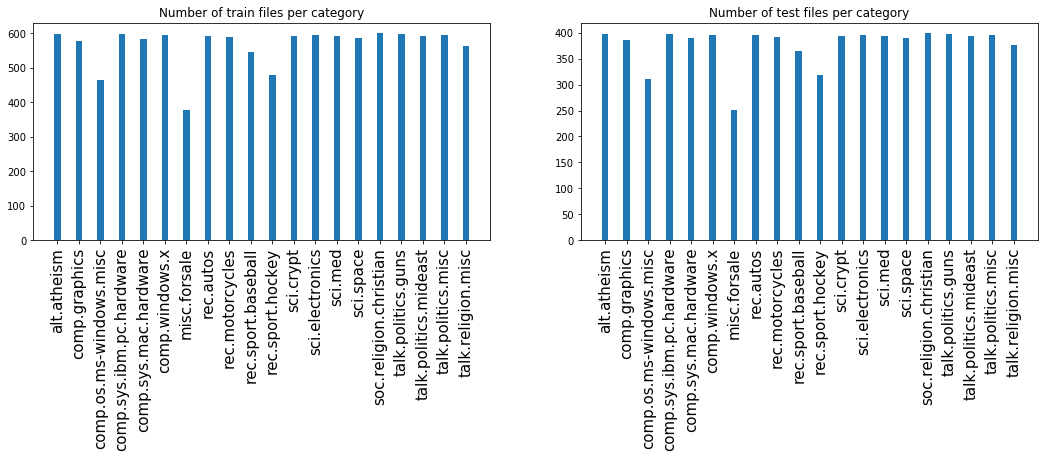

In [36]:
fig,axes = plt.subplots(1,2 ,figsize = (18,4))

plt.axes(axes[0])
x= range(len(categories))
y = trainFilesPerCat.values()
plt.bar(x,y,width=0.3,alpha=1)
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories,rotation=90,fontsize=15)
axes[0].set_title('Number of train files per category')

plt.axes(axes[1])
y = testFilesPerCat.values()
plt.bar(x,y,width= 0.3)
axes[1].set_xticks(x)
axes[1].set_xticklabels(categories,rotation=90,fontsize=15)
axes[1].set_title('Number of test files per category')
plt.show()



# Histogram of sentence and word counts per file

It can be seen that most files have less than 40 sentences and median is close to 20. Also most files have less than 400 words with max word count of 8155 and minimum word count of 9. (Please note that this is after removing the punctuation and stop words)

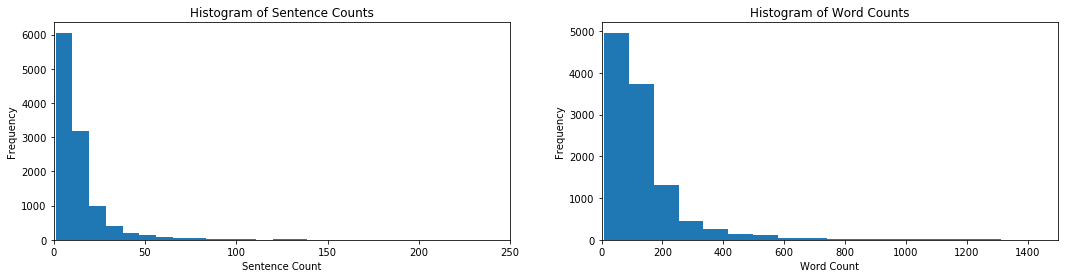

Max word count: 8155 Min word count: 9 Median word count: 100.0


In [37]:
#Histogram of Sentence counts
trainFileStats = pd.DataFrame(trainFileStats)  
sentencesPerFile = trainFileStats[0]
wordsPerFile = trainFileStats[1]
fig,axes = plt.subplots(1,2,figsize = (18,4))

plt.axes(axes[0])
plt.hist(sentencesPerFile,bins=100)
axes[0].set_xlim([0,250])
axes[0].set_xlabel('Sentence Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Sentence Counts')

plt.axes(axes[1])
plt.hist(wordsPerFile,bins=100)
axes[1].set_xlim([0,1500])
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Word Counts')
plt.show()
print 'Max word count:',np.max(wordsPerFile),'Min word count:',np.min(wordsPerFile),'Median word count:',np.median(wordsPerFile)


## Total words across whole training data

The total number of unique words after removing stop words are 259744. This is a huge feature set as compared to number of sample in training data. I am going to reduce this number by setting parameters while doing vectorization of text.

In [270]:
# After removing stop words and punctuation
tdict={}
for i in range(len(X_train_data)):
    tokens = X_train_data[i].split()
    for t in tokens:
            if t not in tdict:
                tdict[t] = 1
            else:
                tdict[t] = tdict[t] + 1
word_count = pd.DataFrame.from_dict(tdict,orient='index')       
word_count.columns = ['count']
word_count = word_count.sort('count',ascending=False)
word_count.shape        



C:\Users\nnagori\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


(258055, 1)

# Top 100 word counts plot

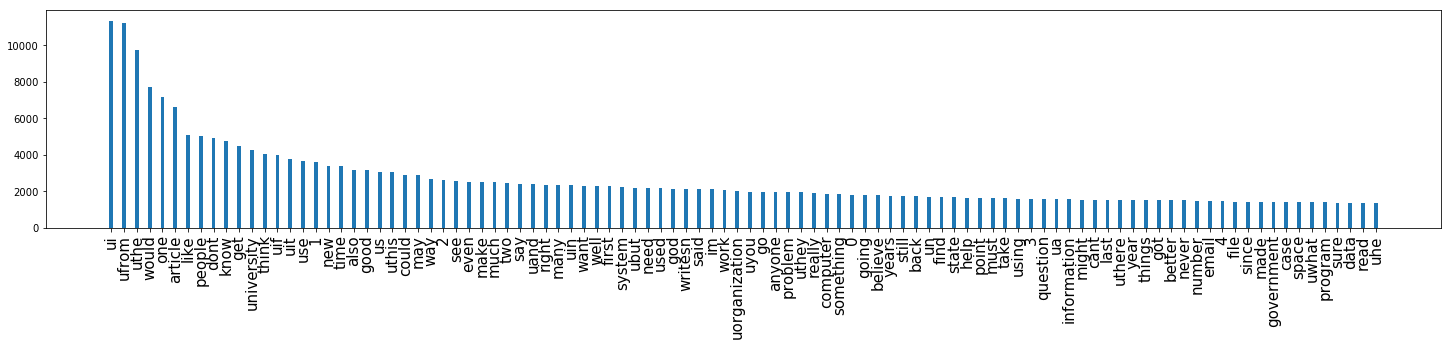

In [271]:


x = range(100)
y = word_count.head(100)['count']

fig,axes = plt.subplots(1,figsize = (25,4))
plt.bar(x,y,width= 0.3)
axes.set_xticks(x)
xtickname = axes.set_xticklabels(word_count.index[0:100])
plt.setp(xtickname,rotation = 90,fontsize = 15)
plt.show()


# Classifiers

I imported Multinomial Naive Bayes classifer from sklearn.naive_bayes, trained them on the extracted feature matrix and predicted the categories on testing feature matrix. I used deafult parameter for now. I used grid search to find best parameters afterwards.

In [272]:

clf = MultinomialNB().fit(X_train,Y_train)
print "Training data Accuracy:", (100 * clf.score(X_train, Y_train)),"%"
print "Test data Accuracy:", (100 * clf.score(X_test, Y_test)),"%"


Training data Accuracy: 96.9506805727 %
Test data Accuracy: 81.014338821 %


In [41]:

rf_clf = RandomForestClassifier().fit(X_train,Y_train)
print "Training data Accuracy:", (100 * rf_clf.score(X_train, Y_train)),"%"
print "Test data Accuracy:", (100 * rf_clf.score(X_test, Y_test)),"%"


Training data Accuracy: 99.8585822874 %
Test data Accuracy: 60.4221986192 %


In [42]:
#svm_clf = SGDClassifier(alpha=0.0001,loss='modified_huber',n_iter=50).fit(X_train,Y_train)
#svm_clf = SVC(kernel='linear',C=1).fit(X_train,Y_train)- slowest of all
svm_clf = LinearSVC().fit(X_train,Y_train)# - aLways give global minima
print "Training data Accuracy:", (100 * svm_clf.score(X_train, Y_train)),"%"
print "Test data Accuracy:", (100 * svm_clf.score(X_test, Y_test)),"%"


Training data Accuracy: 99.9823227859 %
Test data Accuracy: 84.9309612321 %


## Top 10 features for all classes using Naive Bayes

In [274]:
def get_top10(vectorizer, clf, categories):
    featureWeight = {}a
    """Get features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
   
    for i, cat in enumerate(categories):
        top10 = np.argsort(clf.coef_[i])[-10:]
        featureWeight[cat] = [[feature_names[j] for j in top10],vectorizer.idf_[top10]]
        print cat,':'," ".join(feature_names[j] for j in top10)
    return featureWeight   

featureWeight =get_top10(vectorizer,clf,categories)      
featureWeight = pd.DataFrame(featureWeight)



alt.atheism : ui morality allan dont people keithccocaltechedu article keith atheists god
comp.graphics : file uthanks need looking files image university ui 3d graphics
comp.os.ms-windows.misc : using university use driver files ui dos file 31 windows
comp.sys.ibm.pc.hardware : disk university pc bus scsi controller ide ui card drive
comp.sys.mac.hardware : monitor know university simms drive centris quadra ui apple mac
comp.windows.x : program use using x11r5 widget application ui motif server window
misc.forsale : salenorganization condition sell new interested email university shipping offer sale
rec.autos : new good dealer like uthe engine article ui cars car
rec.motorcycles : riding like bmw ride motorcycle bikes ui article dod bike
rec.sport.baseball : ui season runs games article players team game year baseball
rec.sport.hockey : games teams cup players university play nhl game hockey team
sci.crypt : escrow secret nsa crypto government keys encryption chip key clipper
sci.elec

## Top 10 features barplot

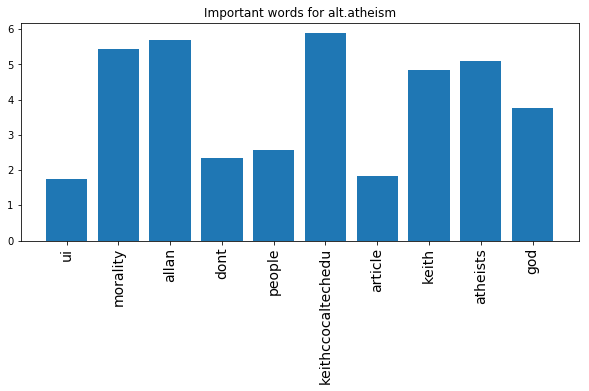

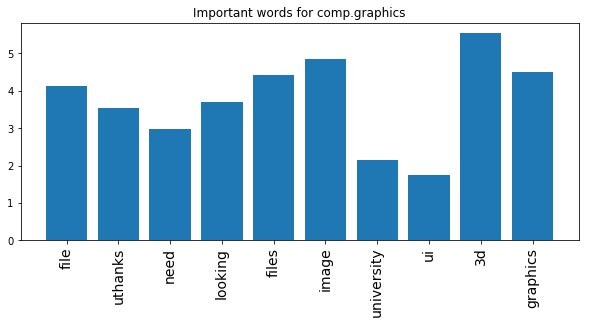

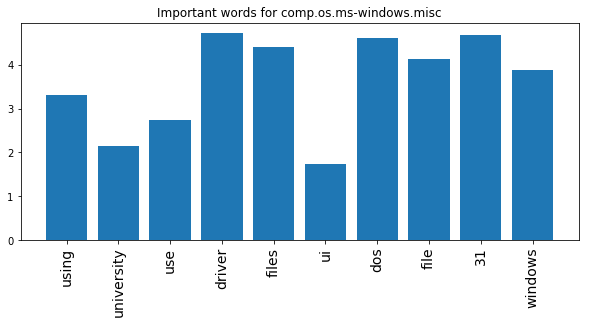

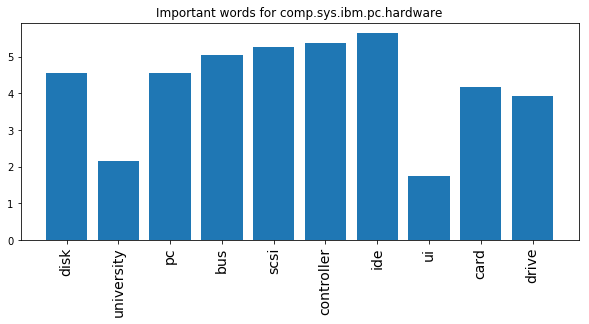

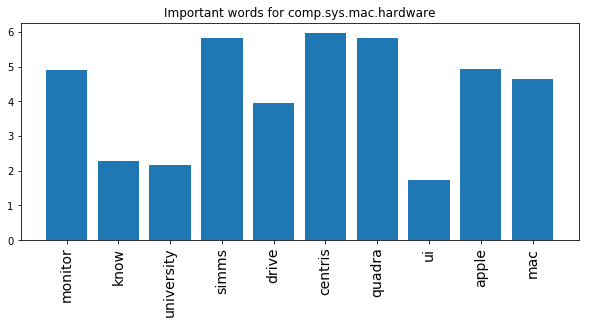

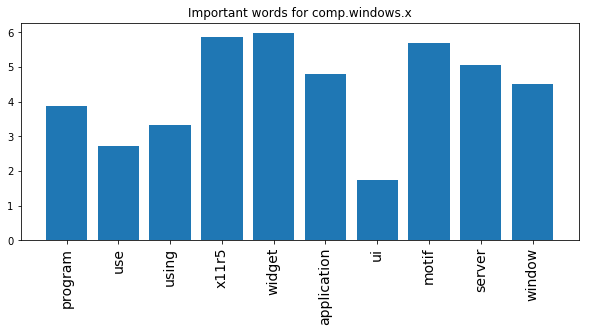

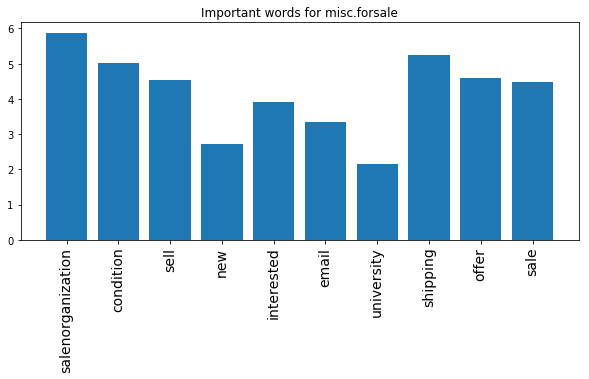

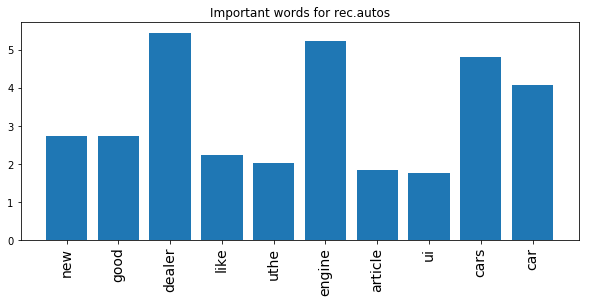

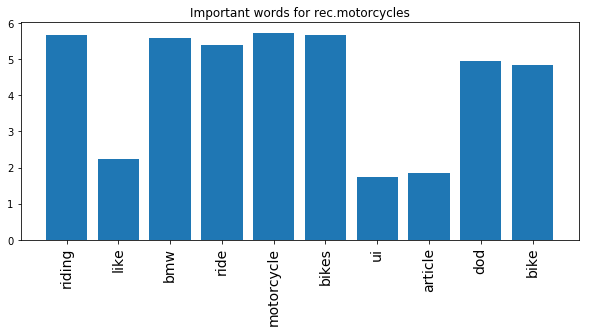

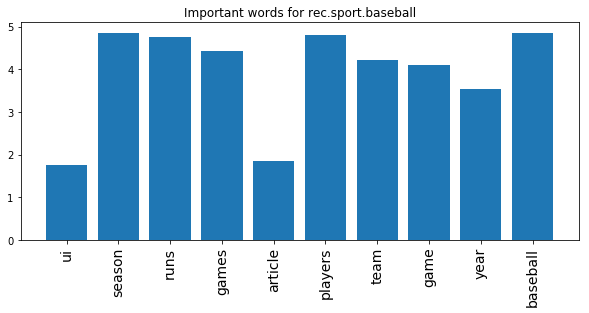

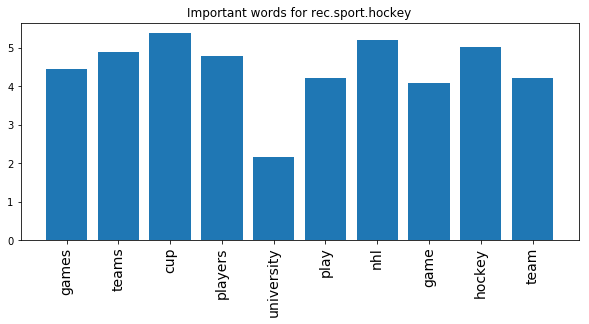

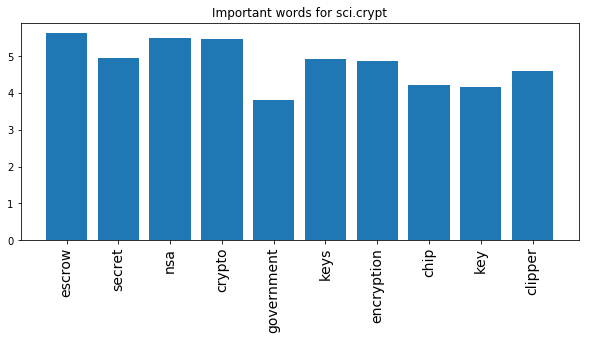

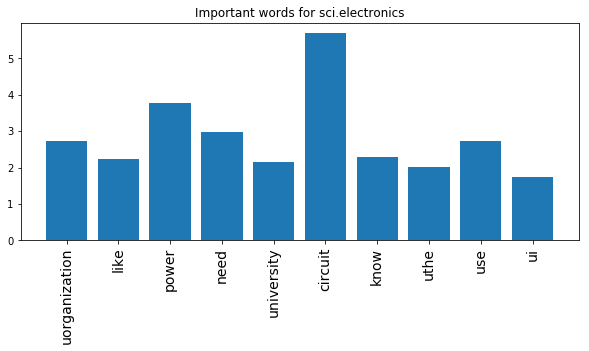

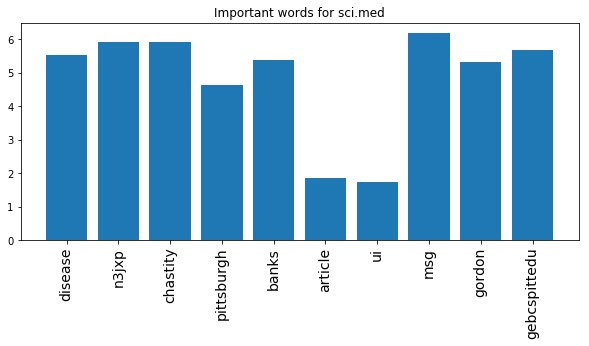

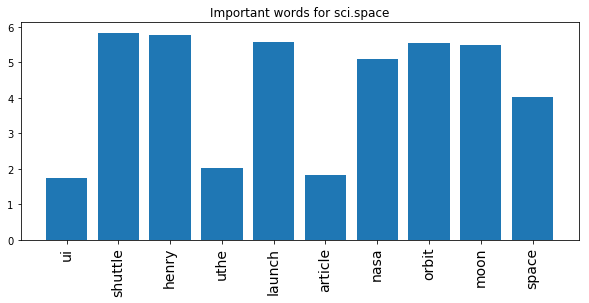

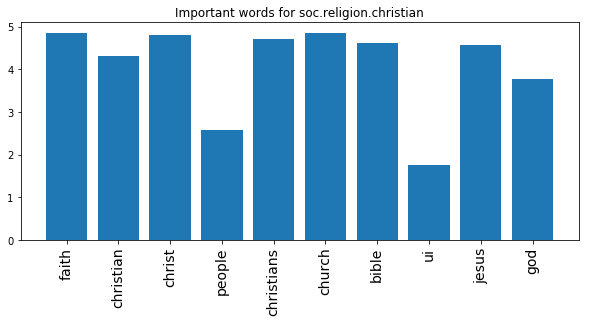

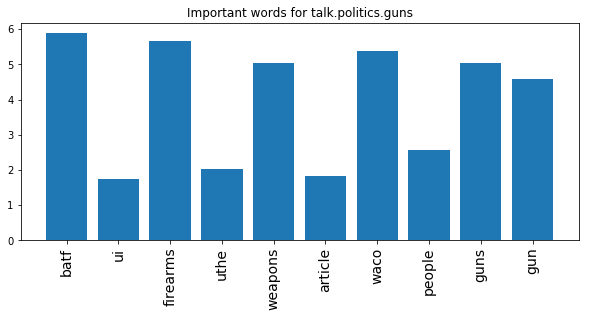

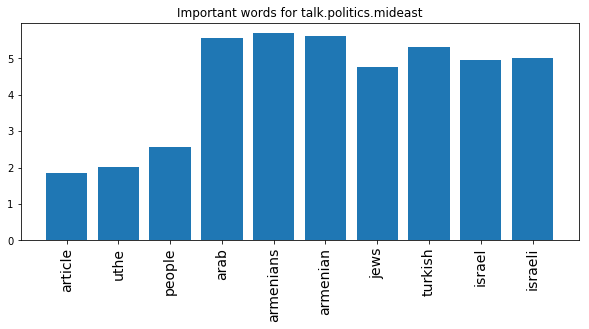

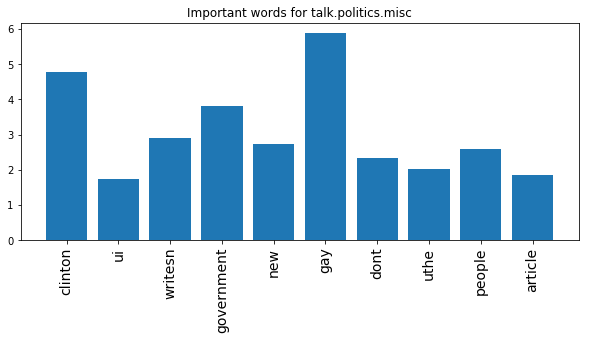

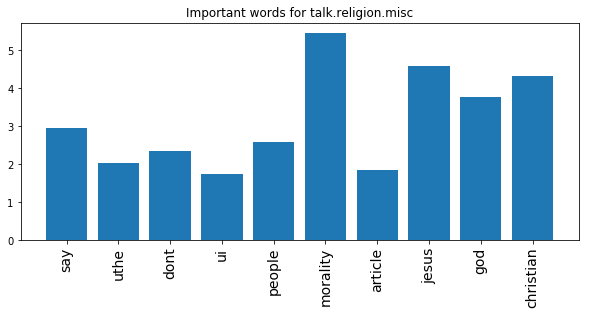

In [45]:
def feature_barplot(category,features,weights):
    
    fig,axes = plt.subplots(1, figsize= (10,4))
    x = range(len(features))
    y = weights
    plt.bar(x,y)
    axes.set_xticks(x)
    axes.set_title("Important words for " + cat)
    xName = axes.set_xticklabels(features)
    plt.setp(xName,rotation = 90,fontsize=14)
    plt.show()


for cat in categories:
    features = featureWeight[cat][0]
    weights  = featureWeight[cat][1]
    feature_barplot(cat,features,weights)

The barplots show that certain important words were indeed related to specific categories.For example, in the  ‘3d',’image’, graphics' are very important for  'comp.graphics' topics like and ‘faith, Christian, ‘god’, ‘bible’ are important  topics for ‘soc.religion.christian’. These also proved that the Multinomial model works well on this dataset

## Finding best parameters using gridsearch

In [46]:

nb_clf = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer(stop_words = 'english',min_df=3)),('tfidf', TfidfTransformer()),('clf', nb_clf)])
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': [True, False],'clf__alpha': [0.05,0.1,0.2,0.5]}
gs_nb_clf = GridSearchCV(pipe, parameters, n_jobs=-1)
gs_nb_clf = gs_nb_clf.fit(X_train_data, Y_train_data)

print "Best paramters for Naive bayes are:", gs_nb_clf.best_params_
print "Training data Accuracy:", (100 * gs_nb_clf.score(X_train_data, Y_train_data)),"%"
print "Test data Accuracy:", (100 * gs_nb_clf.score(X_test_data, Y_test_data)),"%"



Best paramters for Naive bayes are: {'vect__ngram_range': (1, 1), 'tfidf__use_idf': True, 'clf__alpha': 0.05}
Training data Accuracy: 99.3017500442 %
Test data Accuracy: 83.7227827934 %


In [47]:

svm_clf = LinearSVC()
pipe = Pipeline([('vect', CountVectorizer(stop_words = 'english',min_df=5)),('tfidf', TfidfTransformer()),('clf', svm_clf)])
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False),'clf__C': (0.1,1,10),'clf__tol':(.1,.01,.001)}
gs_svm_clf = GridSearchCV(pipe, parameters, n_jobs=-1)
gs_svm_clf = gs_svm_clf.fit(X_train_data, Y_train_data)
print "Best paramters for SVM are:", gs_svm_clf.best_params_
print "Training data Accuracy:", (100 * gs_svm_clf.score(X_train_data, Y_train_data)),"%"
print "Test data Accuracy:", (100 * gs_svm_clf.score(X_test_data, Y_test_data)),"%"


Best paramters for SVM are: {'vect__ngram_range': (1, 2), 'clf__tol': 0.01, 'clf__C': 1, 'tfidf__use_idf': True}
Training data Accuracy: 99.9027753226 %
Test data Accuracy: 83.1917153478 %


In [48]:
rf_clf = RandomForestClassifier()

pipe = Pipeline([('vect', CountVectorizer(stop_words = 'english',min_df=5)),('tfidf', TfidfTransformer()),('clf', rf_clf)])
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': [True, False],'clf__n_estimators': [5,10,20,30],'clf__max_depth':[5,10,20,50]}
gs_rf_clf = GridSearchCV(pipe, parameters, n_jobs=-1)
gs_rf_clf = gs_rf_clf.fit(X_train_data, Y_train_data)

print "Best paramters for RF are:", gs_rf_clf.best_params_
print "Training data Accuracy:", (100 * gs_rf_clf.score(X_train_data, Y_train_data)),"%"
print "Test data Accuracy:", (100 * gs_rf_clf.score(X_test_data, Y_test_data)),"%"

Best paramters for RF are: {'vect__ngram_range': (1, 1), 'clf__max_depth': 50, 'tfidf__use_idf': False, 'clf__n_estimators': 30}
Training data Accuracy: 91.8508043132 %
Test data Accuracy: 67.1933085502 %


- NB with alpha = 0.05 gives best performance.
- Linear SVX with C =1 and tol = .01 gives best performance.
- Random forest does not seem to work well on this data set and is overfitting with 99% accuracy on training data and only 67% accuracy on test data.

# Ensemble Classifier

To further improve the accuracy I did ensemble of classifiers. I tried various combinations for classifiers. I also tried co-occurence matrix for features. I finally ended with below classifiers that gave the maximum accuracy on the test data. I used the best parameters found using gridsearch method.

- MultinomialNB(alpha = 0.05)
- RandomForestClassifier(n_estimators = 30,max_depth=50)
- SGDClassifier(alpha=0.0001,loss='modified_huber',n_iter=50)

I created my own definition of ensemble classifier with fit, predict and predict_proba methods. I used cross validation to compute accuracy scores.

In [49]:
clf1 = MultinomialNB(alpha = 0.05)
clf2 = RandomForestClassifier(n_estimators = 30,max_depth=50)
clf3 = SGDClassifier(alpha=0.0001,loss='modified_huber',n_iter=50)
clfs = [clf1,clf2,clf3]

In [50]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
import numpy as np
import operator

class EnsembleClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, clfs, weights=None):
        self.clfs = clfs
        self.weights = weights

    def fit(self, X, y):
        self.clfs_=[]
        for clf in self.clfs:
            self.clfs_.append(clf.fit(X, y))
        return self
    
    def predict(self, X):
        
        maj_vote = np.argmax(self.predict_proba(X),axis=1)

        return maj_vote

    def predict_proba(self, X):

        probas = np.asarray([clf.predict_proba(X)for clf in  self.clfs_])
        avg_proba = np.average(probas,  axis=0, weights=self.weights)
        return avg_proba

In [51]:
from sklearn import cross_validation
np.random.seed(123)
eclf = EnsembleClassifier(clfs, weights=[1,1,1])

for clf, label in zip([clf1, clf2, clf3, eclf], ['Naive Bayes', 'Random Forest', 'SVM', 'Ensemble']):

    scores = cross_validation.cross_val_score(clf, X_train, Y_train, cv=5,scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


Accuracy: 0.88 (+/- 0.02) [Naive Bayes]
Accuracy: 0.70 (+/- 0.02) [Random Forest]
Accuracy: 0.90 (+/- 0.02) [SVM]
Accuracy: 0.90 (+/- 0.02) [Ensemble]


In [52]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label in zip([clf1, clf2, clf3, eclf], ['Naive Bayes', 'Random Forest', 'SVM', 'Ensemble']):

    Y_pred = clf.fit(X_train,Y_train).predict(X_test)
    corr = np.where(Y_pred==Y_test)
    accuracy = float(len(corr[0]))/len(Y_test)
    
    print "Accuracy: %0.2f [%s]" , accuracy, label


Accuracy: %0.2f [%s] 0.835767392459 Naive Bayes
Accuracy: %0.2f [%s] 0.664763674987 Random Forest
Accuracy: %0.2f [%s] 0.849442379182 SVM
Accuracy: %0.2f [%s] 0.854221986192 Ensemble


## Conclusions
- TFIDF with SVM works best for 20 class problem
- Naïve Bayes model also performed comparable to SVM.
- Random forest did not work well on this dataset.
- Ensemble of Naïve Bayes, Random forest and SVM improved test accuracy little bit to 85.71%

I believe for this particular dataset the accuracy results are bit lower because in the bydate version, data is sorted. The test set is all from a later time period than the training set. Topics under discussion shift over time, and so there's enough extra similarity between documents close in time versus temporal movement in what gets posted over time. Model is not able to generalize well because the content of a particular newsgroup drifts over time.

## Comparison to current state of art 

The above ensemble classifier result with accuracy of 85.4 on the test data is very close to current state of the art result on this dataset. There is a recent paper in which they have reported an accuracy of around 86-87% on 20 news group. http://riejohnson.com/paper/lstm-tcat-icml2016.pdf . [table 3 on page 5, the column of 20NG standing for 20 news group. They report a test error rate of 13.3%] 

## Future Work
- Some of the classes are related to each other. There can be a broader group of classes - Computer/Religion/sports/Science/Politics and then classifcation can be carried over these broader topics. 

- Under the same broader class, classifcation can be carried on sub categories. For eg: Under science class - classifcation can be carried over sub categories - crypt,electronics,medical,space